In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!sudo apt-get install openslide-tools
!sudo apt-get install python-openslide
!pip install openslide-python
import openslide

In [ ]:
#Process whole slide images
import os
from xml.dom import minidom
import numpy as np
from openslide import open_slide  
from glob import glob
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio
from PIL import Image
import scipy
import scipy.ndimage
from shapely.geometry import Polygon
from skimage import draw
import xml.etree.ElementTree as ET

In [ ]:
count = 0
data_path = '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_images_and_annotations' #Path to read data from
destination_path = '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1' # Path to save binary masks corresponding to xml files
os.chdir(destination_path)

try:
    os.mkdir(destination_path+'/MoNuSAC_masks/')
except OSError:
    print ("Creation of the mask directory %s failed" % destination_path)
    
os.chdir(destination_path+'/MoNuSAC_masks/')#Create folder named as MoNuSAC_masks
patients = [x[0] for x in os.walk(data_path)]#Total patients in the data_path
len(patients)

48

In [ ]:
for patient_loc in patients:
    patient_name = patient_loc[len(data_path)+1:]#Patient name
    print(patient_name)
    
    ## To make patient's name directory in the destination folder
    try:
        os.mkdir(patient_name)
    except OSError:
        print ("\n Creation of the patient's directory %s failed" % patient_name)
        
    ## Read sub-images of each patient in the data path        
    sub_images = glob(patient_loc+'/*.svs')
    for sub_image_loc in sub_images:
        sub_image_name = sub_image_loc[len(data_path)+len(patient_name)+1:-4]        
        print(sub_image_name)
        
        ## To make sub_image directory under the patient's folder
        sub_image = './'+patient_name+'/'+sub_image_name #Destination path
        try:
            os.mkdir(sub_image)
        except OSError:
            print ("\n Creation of the patient's directory %s failed" % sub_image)
            
        image_name = sub_image_loc
        img = openslide.OpenSlide(image_name)
                                  
        # If svs image needs to save in tif
        cv2.imwrite(sub_image_loc[:-4]+'.tif', np.array(img.read_region((0,0),0,img.level_dimensions[0])))      
   
        # Read xml file
        xml_file_name  = image_name[:-4]
        xml_file_name = xml_file_name+'.xml'
        tree = ET.parse(xml_file_name)
        root = tree.getroot()
        
        #Generate binary mask for each cell-type                         
        for k in range(len(root)):
            label = [x.attrib['Name'] for x in root[k][0]]
            label = label[0]
            
            for child in root[k]:
                for x in child:
                    r = x.tag
                    if r == 'Attribute':
                        count = count+1
                        print(count)
                        label = x.attrib['Name']
                        binary_mask = np.transpose(np.zeros((img.read_region((0,0),0,img.level_dimensions[0]).size))) 
                        print(label)
                        
                        # Create directory for each label
                        sub_path = sub_image+'/'+label
                        
                        try:
                            os.mkdir(sub_path)
                        except OSError:
                            print ("Creation of the directory %s failed" % label)
                        else:
                            print ("Successfully created the directory %s " % label) 
                                          
                        
                    if r == 'Region':
                        regions = []
                        vertices = x[1]
                        coords = np.zeros((len(vertices), 2))
                        for i, vertex in enumerate(vertices):
                            coords[i][0] = vertex.attrib['X']
                            coords[i][1] = vertex.attrib['Y']        
                        regions.append(coords)
                        poly = Polygon(regions[0])  
                        
                        vertex_row_coords = regions[0][:,0]
                        vertex_col_coords = regions[0][:,1]
                        fill_row_coords, fill_col_coords = draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)
                        binary_mask[fill_row_coords, fill_col_coords] = 255
                        mask_path = sub_path+'/'+str(count)+'_mask.tif'
                        cv2.imwrite(mask_path, binary_mask)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import numpy as np
from tqdm import tqdm
import cv2
from glob import glob
import warnings
import random
warnings.filterwarnings('ignore')
import skimage.io
%matplotlib inline

# Helpers

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
        
def read_nuclei(path):
    "Read raw data"

    # Load 4-channel image
    if len(path) == 0:
        return None
    
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)
    
    
    
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


# Root directory of the project
ROOT_DIR = '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1'
print(ROOT_DIR)
# Training file directory
IMAGES_FOLDER = '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSac_Train/'
MASKS_FOLDER = '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_masks/'
print(IMAGES_FOLDER, MASKS_FOLDER)

/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1
/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSac_Train/ /content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_masks/


In [ ]:
IMAGES_DEST =  os.path.join(ROOT_DIR, "data_processedv0", "images/")
MASKS_DEST = os.path.join(ROOT_DIR, "data_processedv0", "masks/")

print(IMAGES_DEST)
print(MASKS_DEST)

# Create folders
create_directory(IMAGES_DEST)
create_directory(MASKS_DEST)

/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/data_processedv0/images/
/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/data_processedv0/masks/


In [ ]:
IMAGES_SUB_FOLDER = [os.path.join(IMAGES_FOLDER, i) for i in sorted(next(os.walk(IMAGES_FOLDER))[1])]
IMAGES_SUB_FOLDER[:5]

['/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSac_Train/TCGA-55-1594-01Z-00-DX1',
 '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSac_Train/TCGA-5P-A9K0-01Z-00-DX1',
 '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSac_Train/TCGA-69-7760-01Z-00-DX1',
 '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSac_Train/TCGA-69-A59K-01Z-00-DX1',
 '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSac_Train/TCGA-73-4668-01Z-00-DX1']

In [ ]:
MASKS_SUB_FOLDER = [os.path.join(MASKS_FOLDER, i) for i in sorted(next(os.walk(MASKS_FOLDER))[1])]
MASKS_SUB_FOLDER[:5]

['/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_masks/TCGA-55-1594-01Z-00-DX1',
 '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_masks/TCGA-5P-A9K0-01Z-00-DX1',
 '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_masks/TCGA-69-7760-01Z-00-DX1',
 '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_masks/TCGA-69-A59K-01Z-00-DX1',
 '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_masks/TCGA-73-4668-01Z-00-DX1']

In [ ]:
a = sorted(next(os.walk(IMAGES_FOLDER))[1])
b = sorted(next(os.walk(MASKS_FOLDER))[1])
print(a[:2], b[:2])

for x,y in zip(a,b):
    if x == y:
        print(True)
    else:
        print(False)

['TCGA-55-1594-01Z-00-DX1', 'TCGA-5P-A9K0-01Z-00-DX1'] ['TCGA-55-1594-01Z-00-DX1', 'TCGA-5P-A9K0-01Z-00-DX1']
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
ct = 10
print(IMAGES_SUB_FOLDER[ct])
print(MASKS_SUB_FOLDER[ct])

/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSac_Train/TCGA-B6-A0WZ-01Z-00-DX1
/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_masks/TCGA-B6-A0WZ-01Z-00-DX1


In [ ]:
## MAIN#########

images = []
masks = []

iterator = 0

raw_ct = 0
gt_ct = 0
!pip install imagecodecs
for ct in tqdm(range(len(IMAGES_SUB_FOLDER[:]))):
    #print(ct)
    
    #print(IMAGES_SUB_FOLDER[ct], MASKS_SUB_FOLDER[ct])

    # Read all raw images in image sub folder
    all_imgs = sorted(glob(IMAGES_SUB_FOLDER[ct] + '/*.tif'))

    # Read the mask sub folders
    all_mask_sub_dir = sorted(glob(MASKS_SUB_FOLDER[ct]+ '/*'))

    # Iterate over the individual raw images
    
    for i in range(len(all_imgs)):

        #print(i)
        img = read_nuclei(all_imgs[i])

        # Save it
        # .............
        
        save_nuclei(IMAGES_DEST+ "{}.png".format(raw_ct), img)
        raw_ct+=1
        
        #print(IMAGES_DEST+ "{}_{}.png".format(ct, i))
        
        # Add to list
        #images.append(img)

    # Iterate over the individual mask sub folders
    for j in range(len(all_mask_sub_dir)):

        # Go to each sub folder
        # Read the 4 class folders
        class_sub_dir = sorted(glob(all_mask_sub_dir[j]+ '/*'))  

        # Make list for masks from each class fodlers
        final_masks = []

        # For each class folder get the mask
        for i in range(len(class_sub_dir)):

            # get the mask in the subfolder
            mask_paths = sorted(glob(class_sub_dir[i] + '/*.tif'))

            # If more than one mask present in folder(maybe not)
            # For each class folder: 1) read the mask 2) Convert to class label from the binary class label
            for j in range(len(mask_paths)):

                if i == 0:
                    epithelial_mask = read_nuclei(mask_paths[j])
                    epithelial_mask = np.where(epithelial_mask==255.0, 1.0, epithelial_mask)
                    final_masks.append(epithelial_mask)

                if i == 1:
                    lymphocyte_mask = read_nuclei(mask_paths[j])
                    lymphocyte_mask = np.where(lymphocyte_mask==255.0, 2.0, lymphocyte_mask)
                    final_masks.append(lymphocyte_mask)
                if i == 2:
                    macrophage_mask = read_nuclei(mask_paths[j])
                    macrophage_mask = np.where(macrophage_mask==255.0, 4.0, macrophage_mask)
                    final_masks.append(macrophage_mask)
                if i == 3:
                    neutrophil_mask = read_nuclei(mask_paths[j])
                    neutrophil_mask = np.where(neutrophil_mask==255.0, 3.0, neutrophil_mask)
                    final_masks.append(neutrophil_mask)

                    
        # Overlay masks
        
        if len(final_masks) == 1:
            
            # If only one mask, read it directly
            mask = final_masks[0]
            
        else:
            
            # For multiple masks, read maximum along the axis
            #mask = np.maximum.reduce(*final_masks, dtype=np.float64)
            mask = np.amax(final_masks, axis=0)
            

        # Save it
        # .............

        mask = mask.astype(np.uint8)
        #print(mask.shape, ct, i, iterator)
        save_nuclei(MASKS_DEST + "{}.png".format(gt_ct), mask)
        gt_ct+=1
        
        iterator+=1

        # Add to list
        #masks.append(mask)
                
    
print(len(images), len(masks))

     |████████████████████████████████| 30.0 MB 1.3 MB/s 


100%|██████████| 46/46 [06:22<00:00,  8.31s/it]

0 0


In [ ]:
print(len(images), len(masks))

0 0


Index:  94
183.png
(500, 786, 3) (500, 786)
Ground truth classes:  [0 1 2 3 4]


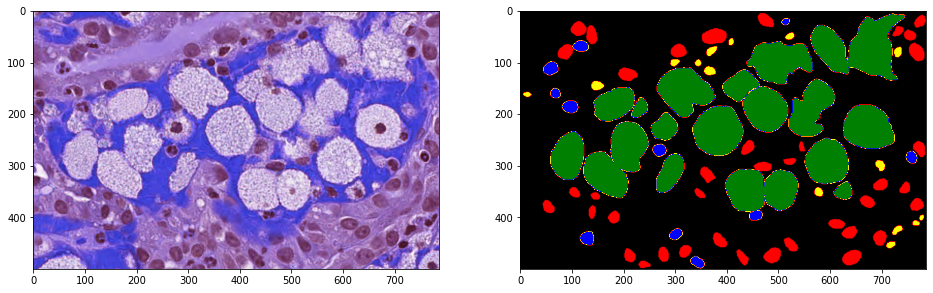

In [ ]:

# Load a random image and mask
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST))[2])

# Random index
idx = 94 #random.randrange(len(image_fns))
print("Index: ", idx)
print(image_fns[idx])
# Read image and mask
image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))

# Test!
assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"
print(image.shape, gt.shape)

# Flatten to get unique -> different classes in the mask
val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))


f, axarr = plt.subplots(1,2, figsize=(16,16))

norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

# idx = 154 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

Index:  59
(109, 90, 3)
Index:  16
(468, 532, 3)
Index:  157
(1302, 1730, 3)
Index:  17
(902, 1220, 3)
Index:  142
(909, 898, 3)
Index:  189
(268, 297, 3)
Index:  127
(687, 712, 3)
Index:  50
(331, 341, 3)
Index:  191
(1310, 951, 3)
Index:  128
(828, 535, 3)


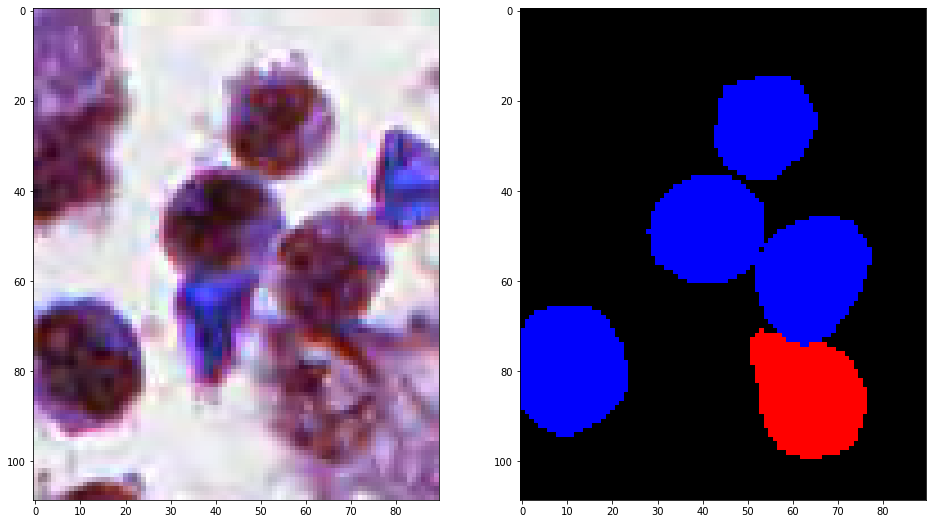

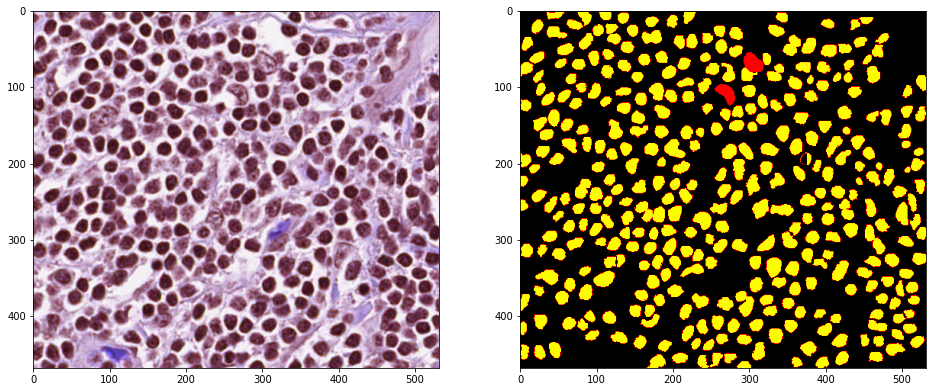

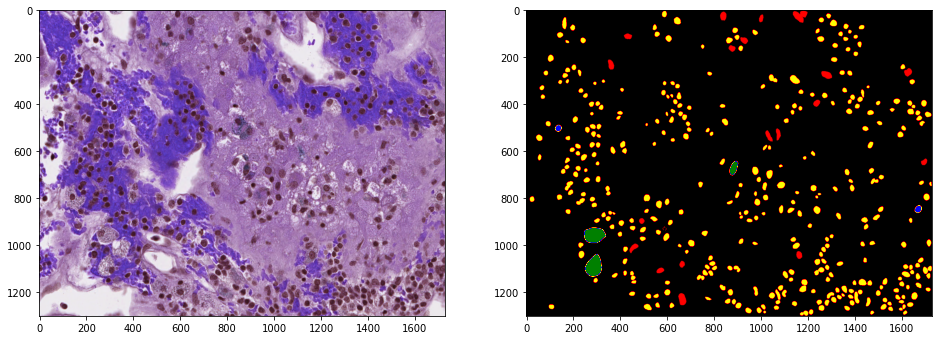

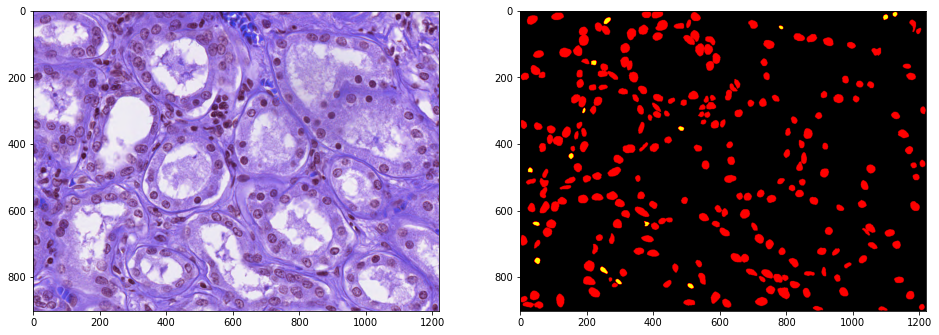

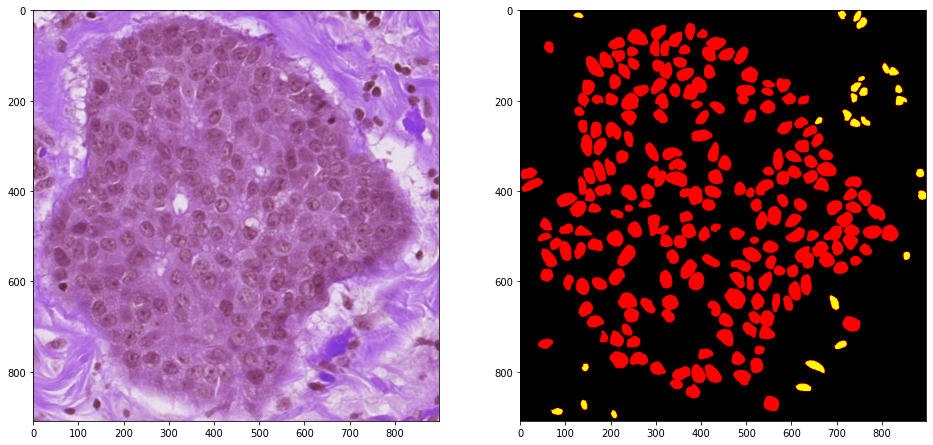

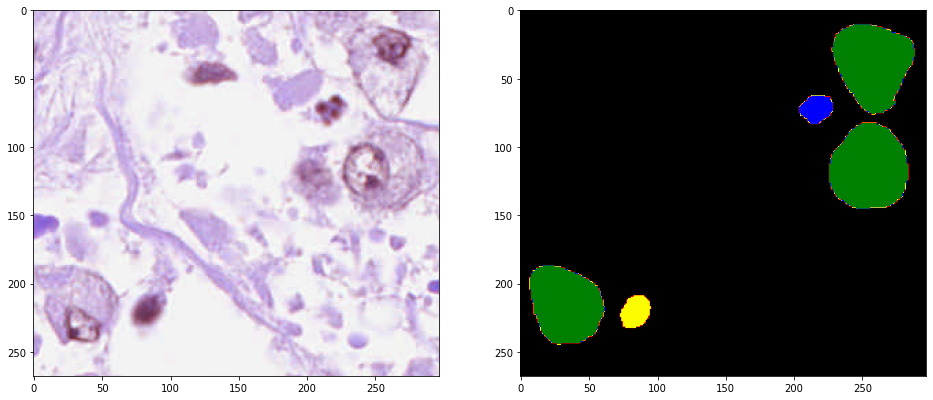

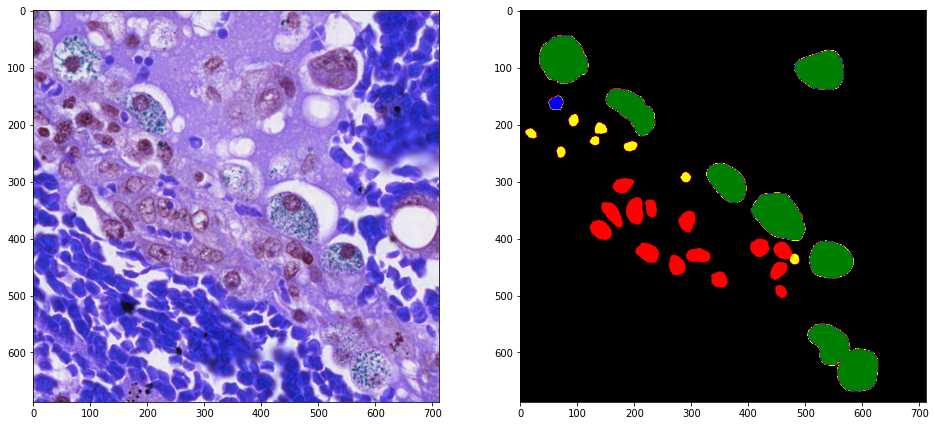

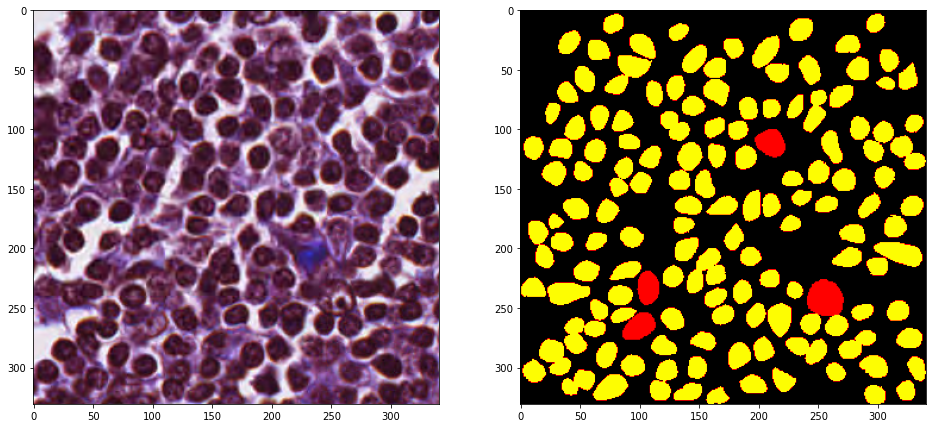

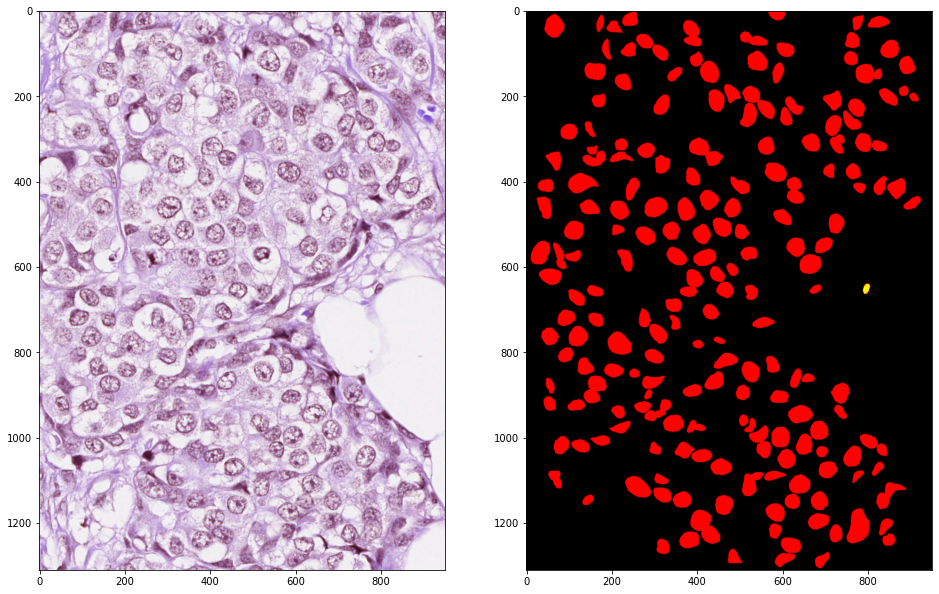

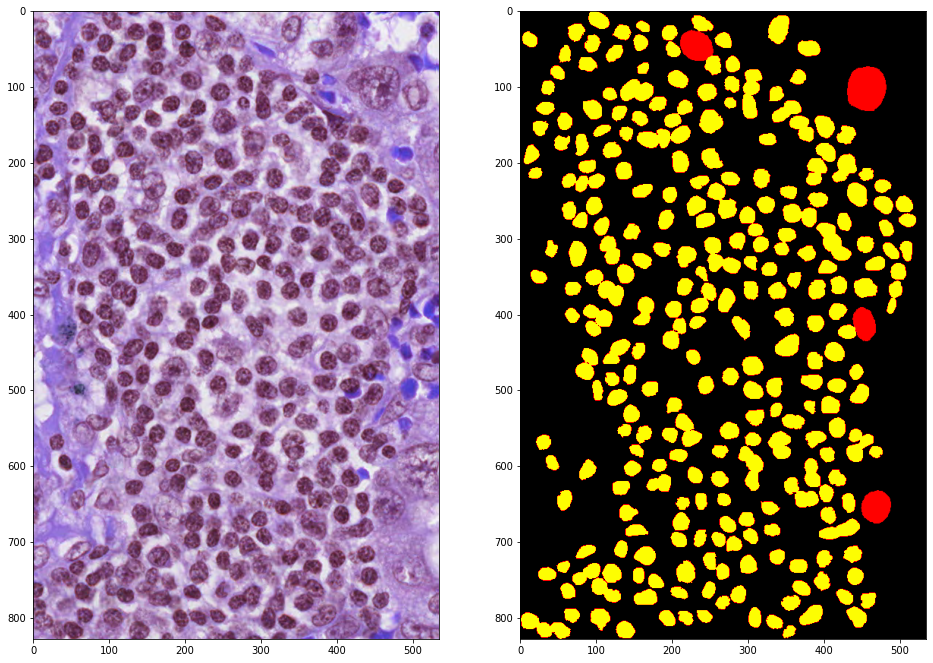

In [ ]:
def process(image, mask):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    axarr[0].imshow(image, cmap=map_name, norm=norm)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)
    
#for img, msk in zip(images, masks):
#    process(img, msk)


#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }


for i in range(10):
    
    idx = random.randrange(len(image_fns))
    print("Index: ", idx)
    
    image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
    gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))
    print(image.shape)
    
    assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
    assert image.dtype == gt.dtype, "Wrong data types!"

    process(image, gt)

In [ ]:
print(gt.shape)

(828, 535)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import skimage.io
import numpy as np
from tqdm import tqdm
import cv2
import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


# Root directory of the project
ROOT_DIR = '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_2'

# Directory of images to run detection on
IMAGES_DEST =  os.path.join(ROOT_DIR, "data_train", "images/")
MASKS_DEST = os.path.join(ROOT_DIR, "data_train", "masks/")



# Make new folders

IMAGES_DEST_v1 =  os.path.join(ROOT_DIR, "data_proc_final_train", "images/")
MASKS_DEST_v1 = os.path.join(ROOT_DIR, "data_proc_final_train", "masks/")

print(IMAGES_DEST_v1)
print(MASKS_DEST_v1)

# Create folders
create_directory(IMAGES_DEST_v1)
create_directory(MASKS_DEST_v1)

/content/drive/MyDrive/Summer_Intern/Project_Final/Data_2/data_proc_final_train/images/
/content/drive/MyDrive/Summer_Intern/Project_Final/Data_2/data_proc_final_train/masks/


In [ ]:
def pad(img, pad_size=128):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 80 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """

    if pad_size == 0:
        return img

    height, width = img.shape[:2]

    if height % pad_size == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = pad_size - height % pad_size
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad

    if width % pad_size == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = pad_size - width % pad_size
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad

    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)



def unpad(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2]

    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]



def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)

    
def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells


def extract_patches(image, step, patch_size):
    
    patches = []
    
    # Get locations
    x_pos, y_pos, cells = sliding_window(image, step, (patch_size[0], patch_size[1]))

    for (x, y, cell) in zip(x_pos, y_pos, cells):

        # Get patch
        patch = image[y:y + patch_size[0], x:x + patch_size[0]]

        # Get size
        raw_dim = (patch.shape[1], patch.shape[0]) # W, H
        #print(raw_dim)
        #print(patch.shape)


        if raw_dim != (patch_size[0], patch_size[1]):

            # Resize to 64x64
            #patch = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
            patch, pad_locs = pad(patch, pad_size=patch_size[0])
            
            # Do stuffffff
            patches.append(patch)
        
        else:

            # Do stuffffff
            patches.append(patch)
    
    patches = np.array(patches)
    
    return patches

Index:  158
(424, 375, 3) (424, 375)
Ground truth classes:  [0 2 3 4]


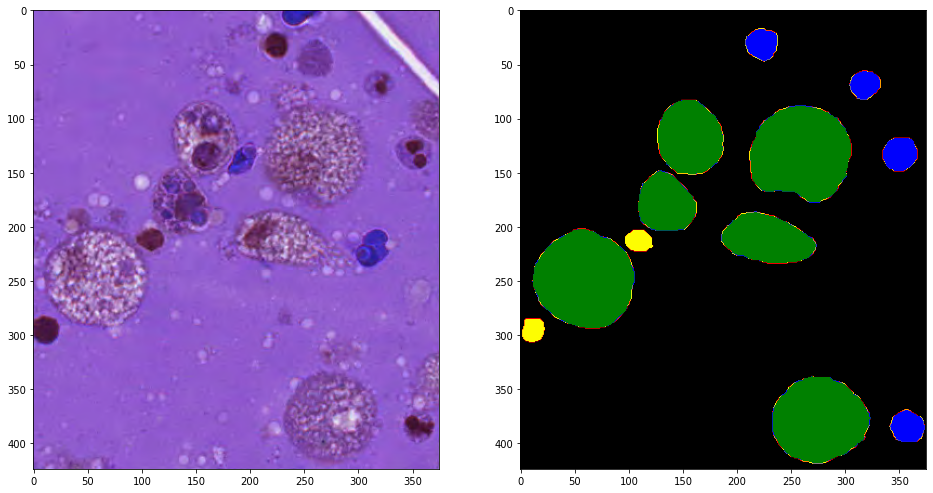

In [ ]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST))[2])


idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))

assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

f, axarr = plt.subplots(1,2, figsize=(16,16))

# idx = 94 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

In [ ]:
img_patches = None
gt_patches = None

patch_size = (128, 128)
step = 110
img_patches = extract_patches(image, step, patch_size)
gt_patches = extract_patches(gt, step, patch_size)

print('Patches shape: {}, {}'.format(img_patches.shape, gt_patches.shape))

Patches shape: (16, 128, 128, 3), (16, 128, 128)


[4, 8, 12, 15, 13]
Patch mask mean: 0.801025390625
Patch mask mean: 1.468017578125
Patch mask mean: 0.0
Patch mask mean: 0.4039306640625
Patch mask mean: 0.035400390625


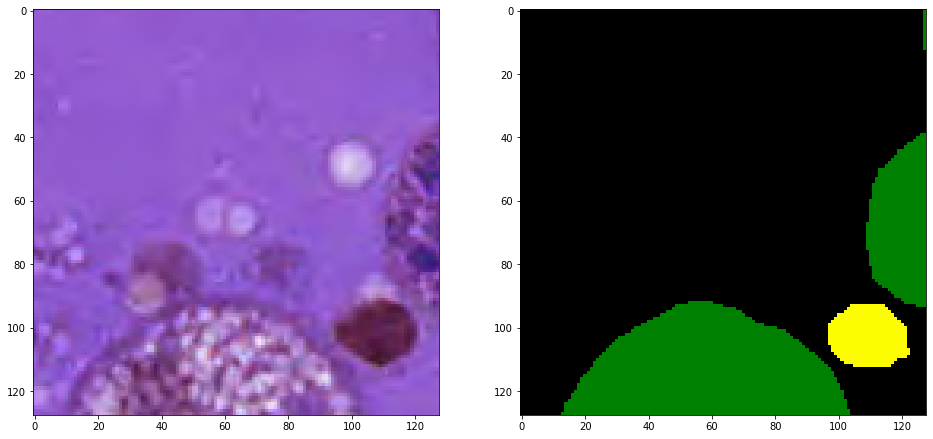

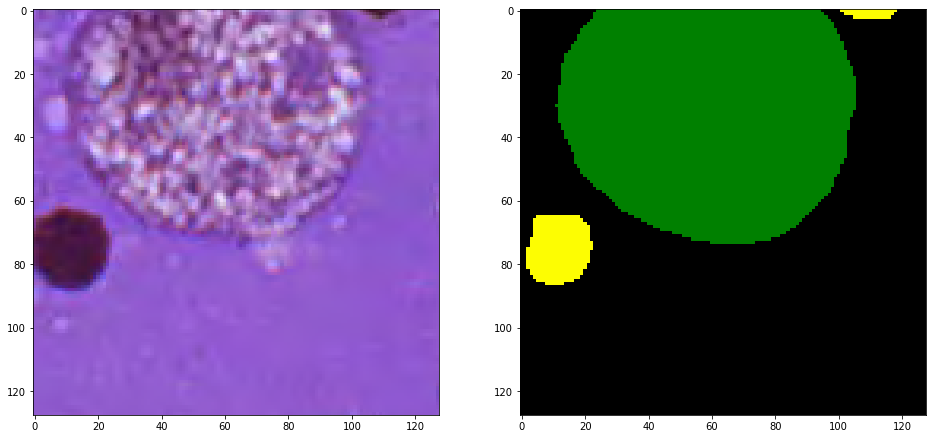

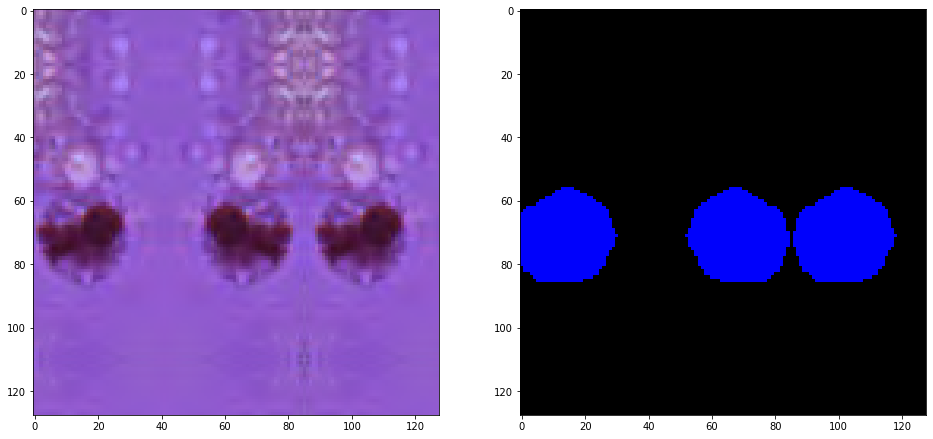

In [ ]:
# Sanity check

def process(image, mask):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    axarr[0].imshow(image, cmap=map_name, norm=norm)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)

    
    
idxs = random.sample(range(0, len(img_patches)),5)
#idxs = [random.randrange(len(img_patches)) for x in range(len(img_patches))] 
print(idxs)
for img, msk in zip(img_patches[idxs], gt_patches[idxs]):
    print("Patch mask mean:", np.mean(msk))
    
    # Set threshold for mask
    thresh= 0.1 #0.099
    if np.mean(msk) < thresh:
        pass
    
    else:
        process(img, msk)

In [ ]:
# Patch size and stride step
patch_size = (128, 128)
step = 110

# Iterate over all image and masks
ct=0

for img_path, gt_path in tqdm(zip(image_fns[:], gt_fns[:])):
    
    #print(img_path, gt_path)
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(IMAGES_DEST, img_path))
    gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_path))
    
    # Extract patches
    img_patches = extract_patches(image, step, patch_size)
    gt_patches = extract_patches(gt, step, patch_size)
    
    if len(gt_patches) == 0:
        print("Not included")

    for im, msk in zip(img_patches, gt_patches):
        
        # Threshold
        if np.mean(msk) < 0.1:
            pass
        
        else:
            # Save image patch 
            save_nuclei(IMAGES_DEST_v1 + "{}.png".format(ct), im)
            # Save mask patch
            save_nuclei(MASKS_DEST_v1 + "{}.png".format(ct), msk)
            ct+=1
        
    image = None
    gt = None
    img_patches = None
    gt_patches = None

189it [02:32,  1.24it/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import skimage.io
import numpy as np
from tqdm import tqdm
import cv2
import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


# Root directory of the project
ROOT_DIR = '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_2'

# Directory of images to run detection on
IMAGES_DEST =  os.path.join(ROOT_DIR, "data_val", "images/")
MASKS_DEST = os.path.join(ROOT_DIR, "data_val", "masks/")



# Make new folders

IMAGES_DEST_v1 =  os.path.join(ROOT_DIR, "data_proc_final_val1", "images/")
MASKS_DEST_v1 = os.path.join(ROOT_DIR, "data_proc_final_val1", "masks/")

print(IMAGES_DEST_v1)
print(MASKS_DEST_v1)

# Create folders
create_directory(IMAGES_DEST_v1)
create_directory(MASKS_DEST_v1)

/content/drive/MyDrive/Summer_Intern/Project_Final/Data_2/data_proc_final_val1/images/
/content/drive/MyDrive/Summer_Intern/Project_Final/Data_2/data_proc_final_val1/masks/


Index:  6
(606, 412, 3) (606, 412)
Ground truth classes:  [0 1 2]


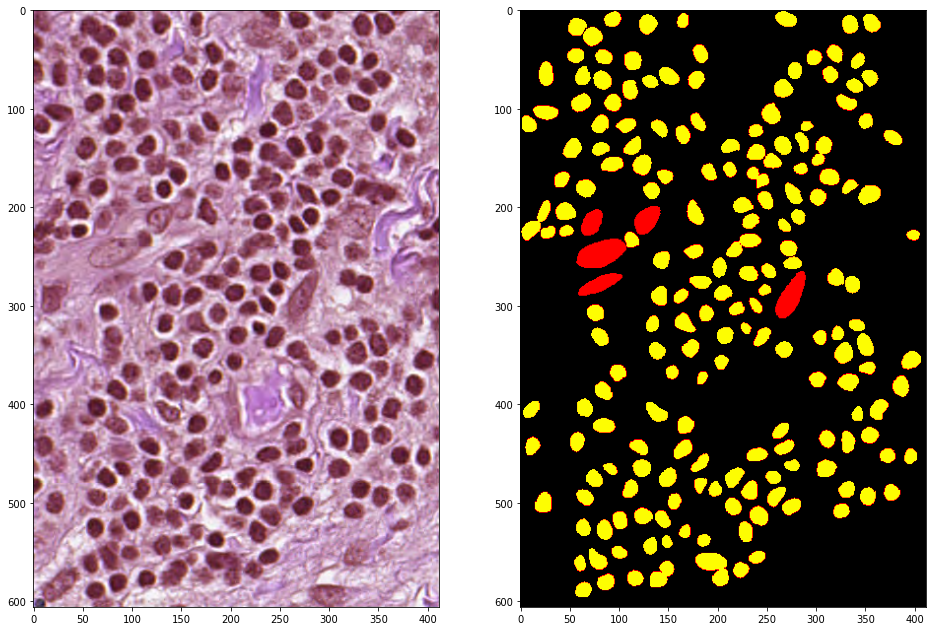

In [ ]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST))[2])


idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))

assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

f, axarr = plt.subplots(1,2, figsize=(16,16))

# idx = 94 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

In [ ]:
# Patch size and stride step
patch_size = (128, 128)
step = 110

# Iterate over all image and masks
ct=0

for img_path, gt_path in tqdm(zip(image_fns[:], gt_fns[:])):
    
    #print(img_path, gt_path)
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(IMAGES_DEST, img_path))
    gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_path))
    
    # Extract patches
    img_patches = extract_patches(image, step, patch_size)
    gt_patches = extract_patches(gt, step, patch_size)
    
    if len(gt_patches) == 0:
        print("Not included")

    for im, msk in zip(img_patches, gt_patches):
        
        # Threshold
        if np.mean(msk) < 0.1:
            pass
        
        else:
            # Save image patch 
            save_nuclei(IMAGES_DEST_v1 + "{}.png".format(ct), im)
            # Save mask patch
            save_nuclei(MASKS_DEST_v1 + "{}.png".format(ct), msk)
            ct+=1
        
    image = None
    gt = None
    img_patches = None
    gt_patches = None

20it [00:13,  1.47it/s]


In [ ]:
image_fns = sorted(next(os.walk(IMAGES_DEST_v1))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST_v1))[2])

image_fns[:5], gt_fns[:5]

(['0.png', '1.png', '10.png', '100.png', '101.png'],
 ['0.png', '1.png', '10.png', '100.png', '101.png'])

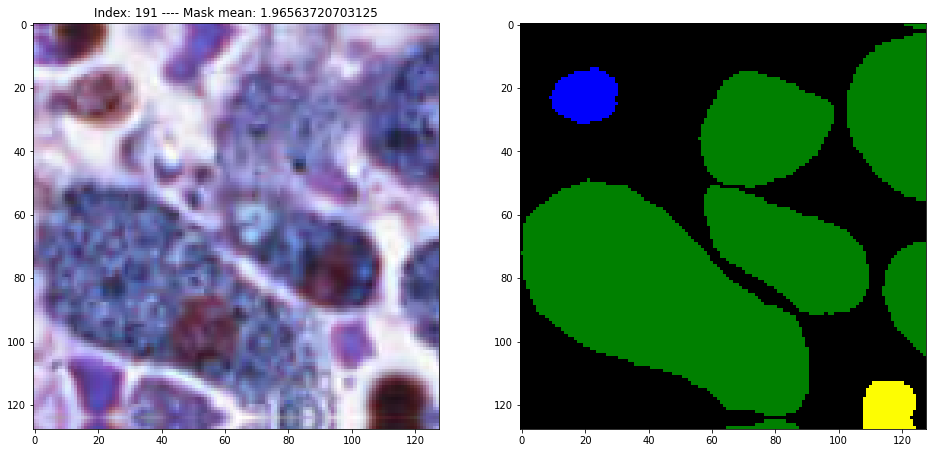

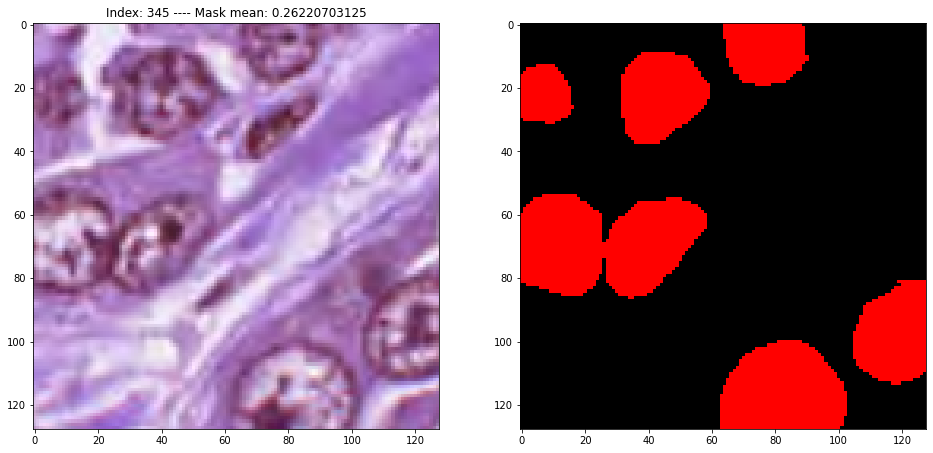

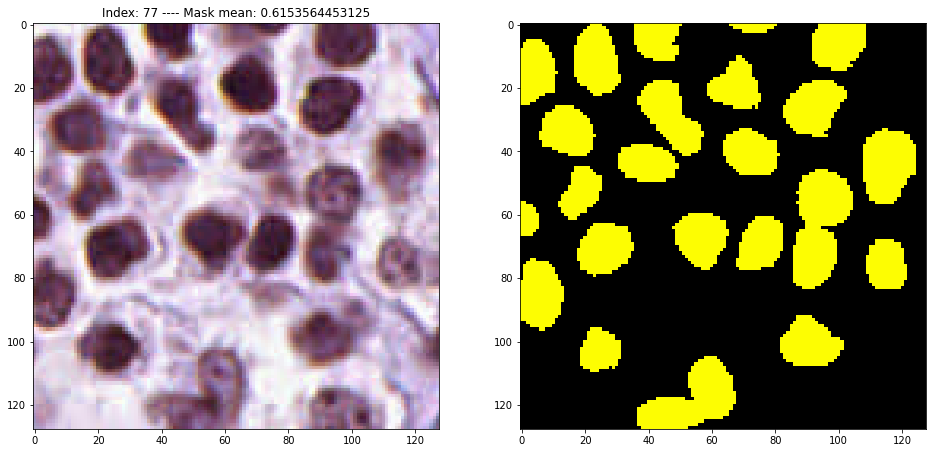

In [ ]:
def process(image, mask, idx):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    # Compute mean of mask
    axarr[0].set_title("Index: {} ---- Mask mean: {}".format(idx, np.mean(mask)))
    
    axarr[0].imshow(image, cmap=map_name, norm=norm)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }


count = 3
for i in range(count):
    
    idx = random.randrange(len(image_fns))
    
    image = skimage.io.imread(os.path.join(IMAGES_DEST_v1, image_fns[idx]))
    gt = skimage.io.imread(os.path.join(MASKS_DEST_v1, gt_fns[idx]))
    
    assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
    assert image.dtype == gt.dtype, "Wrong data types!"
    process(image, gt, idx)

Testing data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import numpy as np
from tqdm import tqdm
import cv2
from glob import glob
import warnings
import random
warnings.filterwarnings('ignore')

%matplotlib inline

# Helpers

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
        
def read_nuclei(path):
    "Read raw data"

    # Load 4-channel image
    if len(path) == 0:
        return None
    
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)
    
    
    
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


# Root directory of the project
ROOT_DIR = '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1'

print(ROOT_DIR)
# Training file directory
IMAGES_FOLDER = os.path.join(ROOT_DIR, "MoNuSAC_Test/")
print(IMAGES_FOLDER)
IMAGES_SUB_FOLDER = [os.path.join(IMAGES_FOLDER, i) for i in sorted(next(os.walk(IMAGES_FOLDER))[1])]
print(IMAGES_SUB_FOLDER[:5])
IMAGES_DEST =  os.path.join(ROOT_DIR, "test_images")
print(IMAGES_DEST)
# Create folders
create_directory(IMAGES_DEST)

/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1
/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_Test/
['/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_Test/TCGA-2Z-A9JG-01Z-00-DX1', '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_Test/TCGA-2Z-A9JN-01Z-00-DX1', '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_Test/TCGA-49-6743-01Z-00-DX2', '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_Test/TCGA-50-6591-01Z-00-DX1', '/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/MoNuSAC_Test/TCGA-55-7570-01Z-00-DX1']
/content/drive/MyDrive/Summer_Intern/Project_Final/Data_1/test_images


In [ ]:
# STORE IMAGES in test folder together

raw_ct = 0
for ct in tqdm(range(len(IMAGES_SUB_FOLDER[:]))):
    
    #print(ct)
    
    # Read all raw images in image sub folder
    all_imgs = sorted(glob(IMAGES_SUB_FOLDER[ct] + '/*.tif'))
    
    paths = [s.split('.')[0][-25:] for s in all_imgs]
    
    
    # Iterate over the individual raw images
    for i in range(len(all_imgs)):
        
        # Read test image
        #print(all_imgs[i])
        img = read_nuclei(all_imgs[i])

        # Save it
        save_nuclei(IMAGES_DEST+ "/{}.png".format(paths[i]), img)
        raw_ct+=1

100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


In [ ]:
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
image_fns[:3]

['GA-49-6743-01Z-00-DX2_001.png',
 'GA-49-6743-01Z-00-DX2_002.png',
 'GA-49-6743-01Z-00-DX2_003.png']

In [ ]:
w = []
h = []

for i in range(len(IMAGES_DEST)):
    image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[i]))
    w.append(image.shape[1])
    h.append(image.shape[0])
    
w = np.array(w)
h = np.array(h)

print(w.shape, h.shape)

(69,) (69,)


In [ ]:

def process(image, mask):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')


def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells

47344it [00:00, 58087.56it/s]


(2150, 1401, 3) (2150, 1401)


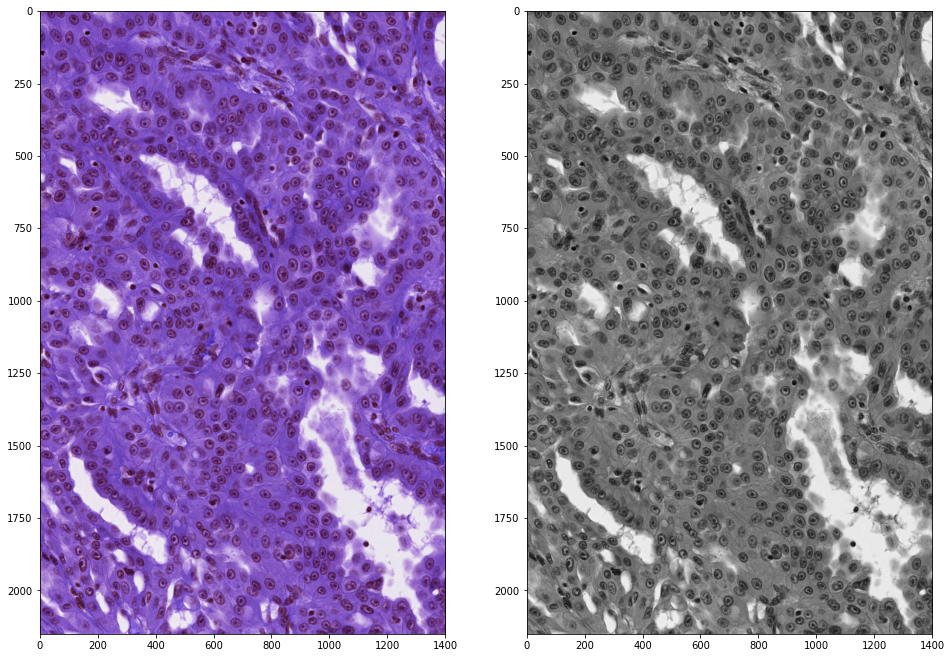

In [ ]:
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])

image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[random.randrange(len(image_fns))]))

# Get locations
x_pos, y_pos, cells = sliding_window(image, 8, (64, 64))

# Array for storing predictions
pred = np.zeros((image.shape[0], image.shape[1]))

for (x, y, cell) in tqdm(zip(x_pos, y_pos, cells)):
    
    # Get patch
    patch = image[y:y + 64, x:x + 64]
    
    # Get size
    raw_dim = (patch.shape[1], patch.shape[0]) # W, H
    #print(raw_dim)
    #print(patch.shape)
    
    
    if raw_dim != (64, 64):
        
        
        # Resize to 64x64
        patch = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
        
        
        # Do stuffffff
        processed = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        
        
        # Resize back to original shape
        processed = cv2.resize(processed, raw_dim, interpolation = cv2.INTER_AREA)
    
    else:
        
        # Do stuffffff
        processed = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    
    
    # Add in dummy image
    pred[y:y + 64, x:x + 64] = processed    

print(image.shape, pred.shape)
process(image, pred)